# 1. Introduction

## 1.1. Problem Statement

The proliferation of online content necessitates effective methods for detecting and moderating harmful language. This project addresses the challenge of classifying online comments into multiple categories of toxicity, such as toxic, severe toxic, obscene, threat, insult, and identity hate. This is formulated as a multi-label classification problem, where each comment can belong to zero, one, or multiple toxicity categories.

## 1.2. Motivation

Automated toxic comment detection is crucial for maintaining healthy online communities, preventing cyberbullying, and reducing the burden on human moderators. Building accurate and robust models contributes significantly to platform safety and user well-being.

## 1.3. Approach

This notebook employs a state-of-the-art approach using a pre-trained Transformer model, specifically BERT (Bidirectional Encoder Representations from Transformers). The core strategy involves:

1. Data Loading and Exploration: Understanding the dataset structure, label distribution, and text characteristics.
2. Data Preprocessing: Cleaning text (minimal for BERT) and tokenizing comments using the specific BERT tokenizer.
3. Model Definition: Loading a pre-trained BERT model and adapting its final layer for multi-label classification.
4. Fine-tuning: Training the BERT model on the toxic comment dataset using appropriate loss functions and optimization techniques.
5. Evaluation: Assessing model performance using relevant multi-label classification metrics (e.g., AUC ROC per label).
6. Prediction: Generating predictions on the test set.
7. (Optional Section) Discussion on advanced techniques like Knowledge Distillation for model compression.

## 1.4. Libraries

We will primarily use the following libraries:

pandas for data manipulation.
numpy for numerical operations.
scikit-learn for splitting data and evaluation metrics.
torch (or tensorflow) as the deep learning framework.
transformers by Hugging Face for accessing pre-trained models (BERT) and tokenizers.
matplotlib and seaborn for data visualization.

# 2. Importing Libraries

In [4]:
pip install torch


     -------------------------------------- 212.4/212.4 MB 5.9 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.10.1
    Uninstalling sympy-1.10.1:
      Successfully uninstalled sympy-1.10.1


In [6]:
pip install transformers

     --------------------------------------- 10.4/10.4 MB 10.4 MB/s eta 0:00:00
     ------------------------------------- 484.3/484.3 kB 10.3 MB/s eta 0:00:00
     -------------------------------------- 308.9/308.9 kB 9.3 MB/s eta 0:00:00
     ---------------------------------------- 2.4/2.4 MB 9.7 MB/s eta 0:00:00
     ------------------------------------- 194.4/194.4 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.7.1
    Uninstalling fsspec-2022.7.1:
      Successfully uninstalled fsspec-2022.7.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # 파일 경로나 환경 변수 등을 다룰 때 사용(예: 모델 저장, 데이터 경로 설정 등)
import re # Regular expressions for text cleaning, 정규 표현식으로 텍스트 전처리(예: 불필요한 문자 제거)

# Deep Learning Framework
import torch  # 전체적으로 텐서 연산, GPU 사용 등 핵심 PyTorch 기능
from torch.utils.data import Dataset, DataLoader  
# Dataset : 커스텀 데이터셋 클래스를 만들 때 사용(텍스트와 레이블을 묶는 클래스 정의)
# DateLoader : Dataset을 배치 단위로 나눠서 모델에 공급

from torch import nn  # nn : 신경망 구성 요소(예: loss function, layer 등)
from torch.optim import AdamW  # AdamW : Transformer 계열 모델에 최적화된 optimizer (Adam with weight decay)

# Hugging Face Transformers
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

#  BertTokenizer : 문장을 토큰화해서 BERT 입력 형태로 변환
#  BertForSequenceClassification : BERT를 기반으로 분류 작업을 수행하는 모델 구조
#  get_linear_schedule_with_warmup : 학습 초반에는 learning rate를 천천히 올리고 이후 선형 감소시키는 학습률 스케쥴링 기법

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, hamming_loss, accuracy_score 
# Accuracy is less informative for multi-label

# train_test_split : 데이터를 학습 / 검증 세트로 나누는 데 사용
# roc_auc_score : ROC, AUC 평가 지표 (멀티라벨 분류에서도 유용)
# classification_report : 정밀도, 재현율, F1 score 등을 정리한 리포트 생성
# hamming_loss : 멀티라벨 분류에서 틀린 레이블 비율을 측정
# accuracy_score : 전체 정확도 (하지만 멀티라벨에서는 정보가 제한적으로 주석이 달린 것처럼 사용에 주의)

In [8]:
# set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)  # CPU 연산에서 무작위 요소 고정
torch.cuda.manual_seed_all(SEED)  # CUDA(GPU)에서도 동일하게 고정

# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
# 난 CPU라서 좀 수정
# BATCH_SIZE 16 -> 4  병렬 처리 크기
# MAX_LENGTH 128 -> 64 문장 길이를 줄임
# EPOCHS 3 -> 1  전체 데이터 셋을 몇 번 반복해서 학습할지

# Configuration (Adjust these as needed)
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 64 # Max sequence length BERT can handle (adjust based on EDA)
BATCH_SIZE = 4 # Adjust based on GPU memory
EPOCHS = 1 # Number of training epochs (BERT fine-tuning usually requires few epochs)
LEARNING_RATE = 2e-5 # Common learning rate for BERT fine-tuning

# 3. Loading Data

In [12]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
smaple_submission_df = pd.read_csv("sample_submission.csv")

In [13]:
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

Train Data Shape: (159571, 8)
Test Data Shape: (153164, 2)


In [14]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [17]:
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [16]:
test_df

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


# 4. Exploratory Data Analysis (EDA)

## 4-1. Target Label Distribution

In [19]:
# calculate label counts and percentages
label_counts = train_df[label_cols].sum()
label_counts

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [21]:
label_percentages = (label_counts / len(train_df)) * 100
label_percentages

toxic            9.584448
severe_toxic     0.999555
obscene          5.294822
threat           0.299553
insult           4.936361
identity_hate    0.880486
dtype: float64

In [23]:
# Create a DataFrame for plotting
label_stats_df = pd.DataFrame({"count" : label_counts, "percentage" : label_percentages})
label_stats_df

,count,percentage
toxic,15294,9.584448
severe_toxic,1595,0.999555
obscene,8449,5.294822
threat,478,0.299553
insult,7877,4.936361
identity_hate,1405,0.880486


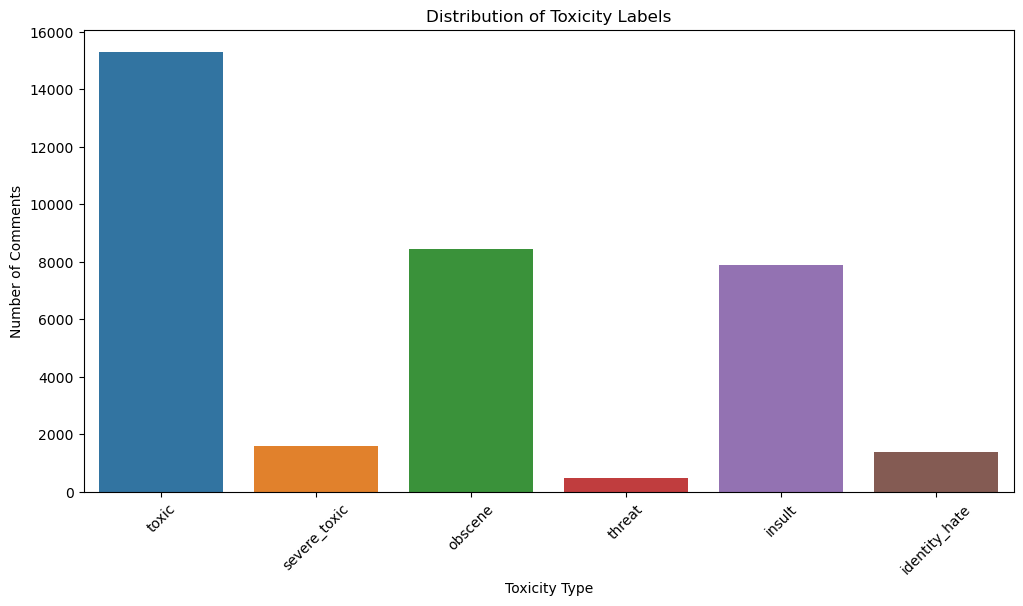

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(x=label_stats_df.index, y=label_stats_df['count'])
plt.title('Distribution of Toxicity Labels')
plt.ylabel('Number of Comments')
plt.xlabel('Toxicity Type')
plt.xticks(rotation=45)
plt.show()

In [26]:
# check for comments with no labels (clean comments)
no_label_count = len(train_df[train_df[label_cols].sum(axis=1) == 0])
no_label_count

143346

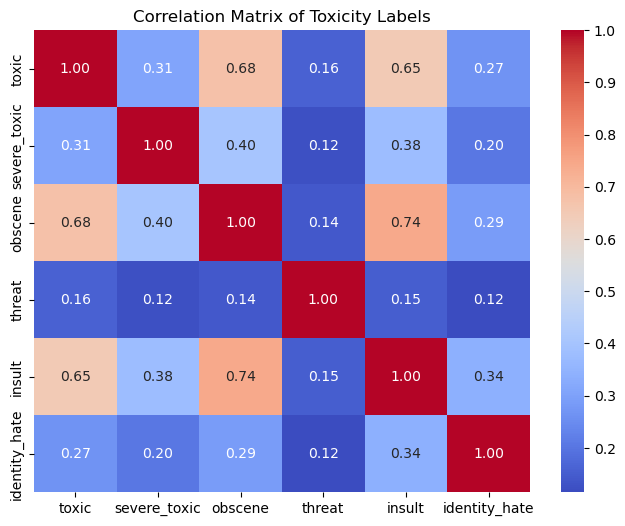

In [27]:
# Multi-label Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[label_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Toxicity Labels')
plt.show()

High correlation between 'toxic' and 'obsence' & 'insult'\
Severe toxic implies toxic

## 4-2. Comment Length Analysis

In [28]:
train_df["comment_length"] = train_df["comment_text"].apply(lambda x : len(x.split()))
test_df["comment_length"] = test_df["comment_text"].apply(lambda x : len(x.split()))

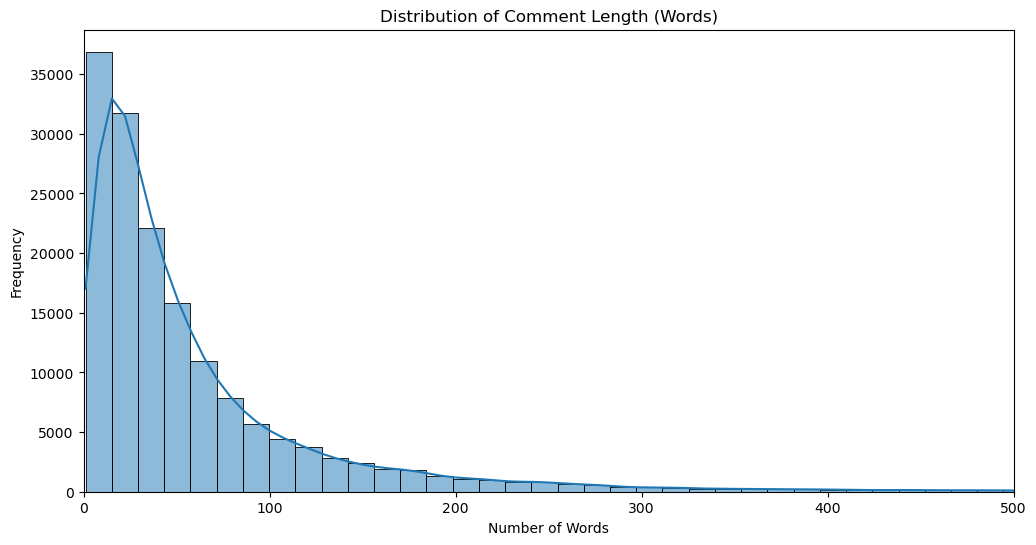

In [29]:
plt.figure(figsize=(12, 6))
sns.histplot(train_df["comment_length"], bins=100, kde=True)
plt.title("Distribution of Comment Length (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

plt.xlim(0, 500)
plt.show()

Most comments are well below 512 tokens, but some are longer.\
Max_length = 128 or 256 might be reasonable start

# 5. Data Processing & Tokenization

## 5.1. Text Cleaning(Minimal for BERT)

In [30]:
def clean_text(text):
    text = str(text)
    # remove URLs (optional, BERT might handel some context)
    
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [37]:
train_df["comment_text_cleaned"] = train_df["comment_text"]
test_df["comment_text-cleaned"] = test_df["comment_text"]

## 5.2. Tokenization with BERT Tokenizer

In [32]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Example tokenization
sample_text = "This is a sample comment for tokenization."
tokens = tokenizer.encode_plus(
    sample_text,
    max_length=32,        # 최대 길이를 32로 제한
    padding='max_length', # Pad to max_length // 문장이 짧으면 빈 부분은 0으로 패딩
    truncation=True,      # Truncate longer sequences // 문장이 너무 길면 잘라냄
    return_tensors='pt'   # Return PyTorch tensors // 결과를 Pytorch tensor 형태로 반환
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\cloud\anaconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cloud\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [33]:
print("\nSample Tokenization:")
print(f"Text: {sample_text}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])}")
print(f"Input IDs: {tokens['input_ids']}")
print(f"Attention Mask: {tokens['attention_mask']}")


Sample Tokenization:
Text: This is a sample comment for tokenization.
Tokens: ['[CLS]', 'this', 'is', 'a', 'sample', 'comment', 'for', 'token', '##ization', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs: tensor([[  101,  2023,  2003,  1037,  7099,  7615,  2005, 19204,  3989,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


## 5.3. Creating Pytorch Datasets and DataLoaders

In [34]:
class ToxicCommentDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        target = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,
            return_token_type_ids=False, # Not needed for basic BERT classification
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt', # Return PyTorch tensors
        )

        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(target, dtype=torch.float) # Use float for BCEWithLogitsLoss
        }

In [38]:
X = train_df["comment_text_cleaned"].values
y = train_df[label_cols].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size = 0.1,
    random_state=SEED
)

In [39]:
train_dataset = ToxicCommentDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = ToxicCommentDataset(X_val, y_val, tokenizer, MAX_LENGTH)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
data = next(iter(train_dataloader))

print("\nSample batch shapes:")
print("Input IDs:", data['input_ids'].shape)
print("Attention Mask:", data['attention_mask'].shape)
print("Labels:", data['labels'].shape)

# 6. Model Definition

In [ ]:
model = BetroForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = len(label_cols),
    output_attentions=False,   # set true if want attention weights
    output_hidden_states=False   # sest True if want hidden states
)

model.to(device)

# 7. Model Training

## 7-1. Setup Optimizer and Scheduler

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * EPOCHS

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Optional: set a number of warmup steps (e.g., 0.1 * total_steps)
    num_training_steps=total_steps
)

# Loss function for multi-label classification
# BCEWithLogitsLoss combines a Sigmoid layer and Binary Cross Entropy loss in one class.
# It's numerically more stable than using a plain Sigmoid followed by BCE Loss.
loss_fn = nn.BCEWithLogitsLoss().to(device)

## 7-2. Training Loop

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    for i, batch in enumerate(data_loader):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits # Raw model output (before sigmoid)

        # Calculate loss
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients (common practice)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()
        scheduler.step() # Update learning rate

        # Print progress (optional)
        if (i + 1) % 100 == 0:
             print(f'  Batch {i + 1}/{num_batches} | Loss: {loss.item():.4f}')


    avg_train_loss = total_loss / num_batches
    print(f"\n  Average Training Loss: {avg_train_loss:.4f}")
    return avg_train_loss

## 7-3. Evaluation Loop

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval() # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []
    num_batches = len(data_loader)

    with torch.no_grad(): # Disable gradient calculation
        for batch in data_loader:
            # Move batch to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits

            # Calculate loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Store predictions (probabilities) and true labels
            # Apply sigmoid to logits to get probabilities
            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_val_loss = total_loss / num_batches
    print(f"  Average Validation Loss: {avg_val_loss:.4f}")

    # Concatenate results from all batches
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Calculate metrics (example: ROC AUC per label, then average)
    # Note: Handling potential errors if a label has only one class in the validation batch/set
    roc_auc_scores = {}
    mean_roc_auc = 0
    try:
        # Calculate AUC for each label individually
        for i, label_name in enumerate(label_cols):
             # Check if both classes are present for the current label
            if len(np.unique(all_labels[:, i])) > 1:
                 roc_auc_scores[label_name] = roc_auc_score(all_labels[:, i], all_preds[:, i])
            else:
                 roc_auc_scores[label_name] = np.nan # Or 0.5, or skip
        # Calculate mean AUC, ignoring NaNs
        mean_roc_auc = np.nanmean(list(roc_auc_scores.values()))
        print(f"  Mean ROC AUC: {mean_roc_auc:.4f}")
        print("  Individual ROC AUC Scores:")
        for name, score in roc_auc_scores.items():
             print(f"    {name}: {score:.4f}")
    except Exception as e:
        print(f"  Could not calculate ROC AUC: {e}")


    # Calculate Hamming Loss (fraction of wrongly predicted labels)
    threshold = 0.5
    binary_preds = (all_preds > threshold).astype(int)
    hamming = hamming_loss(all_labels, binary_preds)
    print(f"  Hamming Loss: {hamming:.4f}")

    # (Optional) You can also calculate Micro/Macro F1 scores or Accuracy (less useful)
    # print("\nClassification Report (threshold=0.5):")
    # print(classification_report(all_labels, binary_preds, target_names=label_cols, zero_division=0))


    return avg_val_loss, mean_roc_auc, hamming # Return key metrics

## 7-4. Execute Training and Evaluation

In [ ]:
history = {'train_loss': [], 'val_loss': [], 'val_roc_auc': [], 'val_hamming': []}
best_roc_auc = -1
best_model_state = None

print("\nStarting Training...")
for epoch in range(EPOCHS):
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')

    train_loss = train_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )
    history['train_loss'].append(train_loss)

    print(f"\n--- Validation Epoch {epoch + 1} ---")
    val_loss, val_roc_auc, val_hamming = eval_model(
        model,
        val_dataloader,
        loss_fn,
        device
    )
    history['val_loss'].append(val_loss)
    history['val_roc_auc'].append(val_roc_auc)
    history['val_hamming'].append(val_hamming)

    # Save the best model based on validation ROC AUC
    if val_roc_auc > best_roc_auc:
        best_roc_auc = val_roc_auc
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'best_model_state.bin')
        print(f"  ** New best model saved with ROC AUC: {best_roc_auc:.4f} **")

print("\nTraining Finished.")
print(f"Best Validation ROC AUC: {best_roc_auc:.4f}")

# Load the best model state for prediction
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model state for prediction.")

## 7-5. Plot Training History

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history['train_loss'], label='Train Loss')
plt.plot(range(1, EPOCHS + 1), history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history['val_roc_auc'], label='Validation Mean ROC AUC')
plt.title('Mean ROC AUC Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()

## Epoch -> 데이터셋 전체를 한 번 학습하는 것

# 8. Prediction on Test Set

## 8-1. Prepare Test Data Loader

In [ ]:
class TestCommentDataset(Dataset):
    def __init__(self, comments, tokenizer, max_len):
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

test_texts = test_df['comment_text_cleaned'].values
test_dataset = TestCommentDataset(test_texts, tokenizer, MAX_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## 8-2. Generate Predictions

In [ ]:
def predict(model, data_loader, device):
    model.eval()
    predictions = []
    print("\nGenerating predictions on test data...")
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            probs = torch.sigmoid(logits) # Convert logits to probabilities (0-1 range)
            predictions.append(probs.cpu().numpy())

    return np.concatenate(predictions, axis=0)

test_predictions = predict(model, test_dataloader, device)
print("Predictions generated successfully.")
print("Shape of predictions:", test_predictions.shape) # Should be (num_test_samples, num_labels)

## 8-3. Format Submission File

In [ ]:
# Create submission DataFrame
submission_df = pd.DataFrame(test_predictions, columns=label_cols)
submission_df['id'] = test_df['id'] # Add the id column

# Reorder columns to match sample_submission.csv format ('id' first, then label columns)
submission_df = submission_df[['id'] + label_cols]

print("\nSubmission DataFrame Head:")
print(submission_df.head())

# Save to CSV
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created successfully.")

# 9. Advanced Techniques: Knowledge Distillation(Discussion)